# Applied Machine Learning A1: Decision Tree, Regression Tree
## Martin Hansson

# Task 1

## Step 1

### Reading  _fetal heart diagnosis data set_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
  
# Read the CSV file.
data = pd.read_csv('CTG.csv', skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
Xtest.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1058,127.0,0.0,0.0,5.0,4.0,0.0,0.0,20.0,2.2,0.0,...,78.0,81.0,159.0,4.0,0.0,131.0,122.0,124.0,23.0,0.0
1694,137.0,14.0,0.0,3.0,5.0,0.0,0.0,58.0,1.7,0.0,...,136.0,52.0,188.0,7.0,1.0,149.0,145.0,158.0,44.0,1.0
531,142.0,9.0,33.0,2.0,0.0,0.0,0.0,38.0,1.3,0.0,...,130.0,68.0,198.0,5.0,0.0,180.0,173.0,177.0,14.0,1.0
1429,144.0,0.0,0.0,5.0,0.0,0.0,0.0,43.0,0.7,1.0,...,40.0,129.0,169.0,1.0,0.0,157.0,154.0,156.0,3.0,0.0
2053,127.0,2.0,2.0,5.0,0.0,0.0,0.0,65.0,1.2,46.0,...,26.0,120.0,146.0,2.0,0.0,126.0,126.0,128.0,1.0,-1.0


## Step 2

### Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
clf = DummyClassifier(strategy='most_frequent')
cross_val_score(clf, Xtrain, Ytrain)

array([0.78235294, 0.78235294, 0.77941176, 0.77941176, 0.77941176])

## Step 3

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_DT = DecisionTreeClassifier(random_state=0)
cross_val_score(clf_DT, Xtrain, Ytrain)

array([0.91470588, 0.94117647, 0.91176471, 0.90588235, 0.94705882])

When using the default values of the decision tree classifier we obtain the result above. However the default depth of the tree will be the depth it takes for all the leaves to be pure or until all leaves contains less then the min_samples_split value, which by default is 2. 
Increasing the max_depth will increase the cross validation score but also puts us in the risk of overfitting to the training data. When trying out different depths of the tree we see that the CV score doesn't increase much, and we are introducing both complexity and risking overfitting while incresing the depth. We keep this in consideration as we move forward with model selection 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_DT_expanded = DecisionTreeClassifier(random_state=0, max_depth=10)
cross_val_score(clf_DT_expanded, Xtrain, Ytrain)

array([0.92941176, 0.93235294, 0.91176471, 0.90882353, 0.94117647])

To counter the overfitting and low predictiveness of decision trees one can utilize a random forest, which is an ensemble of many decision trees which then uses the aggravated result to predict a result. In a random forest all the trees are used in parallel to predict a result, if done for classification problems then it is a majority vote that gives the final result. If used for a regression problem the mean value of the results from the decision trees is the final result. 

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(max_depth=2, random_state=0)
cross_val_score(clf_RF, Xtrain, Ytrain)

array([0.87352941, 0.87941176, 0.86176471, 0.86176471, 0.88529412])

If no value for the max_depth parameter is set for the random forest it will expand fully, setting this value to control the size of the tree is therefor recommended. However the default recommended value of 2 is giving a low CV score, so we also try to let the tree fully expand to determine if it is a good idea to increase the depth or not. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RF_expanded = RandomForestClassifier(max_depth=None, random_state=0)
cv_RF_expanded = cross_val_score(clf_RF_expanded, Xtrain, Ytrain)
print(cv_RF_expanded)
cv_RF_expanded.mean()

[0.93529412 0.95294118 0.93823529 0.94411765 0.94411765]


0.9429411764705883

We see that the random forest when allowed to expand fully gives a better value than the decision tree, which makes this a good candidate model, we can then run diagnostics in order to determine the optimal value for the depth. 

### Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(Xtrain, Ytrain)
cross_val_score(clf_GB, Xtrain, Ytrain)

array([0.90294118, 0.94117647, 0.9       , 0.91470588, 0.92647059])

Similiar to a random forest the gradient boost is a combination of decision trees, however they differ in how they combine the trees as gradient boosting combines the results along the way whilst the random forest combines it in the end.
Gradient boosting performs best when the data at hand does not contain alot of noise, since it then easily can overfit to the data. This makes gradient boosting doubtfull to be the best fit for our data, since we have many covariates
in our data. However to see what the final CV score is when allowing the Gradient boost to expand we try to set the max_depth to None and see the result.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GB_expanded = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=None, random_state=0).fit(Xtrain, Ytrain)
cv_GB_expanded = cross_val_score(clf_GB_expanded, Xtrain, Ytrain)

print(cv_GB_expanded)
cv_GB_expanded.mean()

[0.90294118 0.94117647 0.9        0.91470588 0.92647059]


0.9170588235294117

The executing time for the GradientBoosting is significantly longer since it creates each tree one by one. 
We see that the result is not significantly changed from the random forest, in fact the mean cv score is slightly smaller. Suggesting that the random forest in fact works better om this data.

### Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
clf_P = Perceptron(tol=1e-3, random_state=0)
cross_val_score(clf_P, Xtrain, Ytrain)

array([0.84705882, 0.88529412, 0.82941176, 0.85294118, 0.71176471])

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# The logistic regression model is a linear model which by default uses the liblinear solver which does not converge
# The "libliner", "lbfgs" and "sag" solvers were tried but none converged since the data is high-dimensional
# Setting the solver to "newton-cg"  and multi_class="multinomial" converts the model to a true multinomial regression model which converges for our data.
clf_LR = LogisticRegression(random_state=0, solver="newton-cg", multi_class="multinomial").fit(Xtrain, Ytrain)
cross_val_score(clf_LR, Xtrain, Ytrain)

array([0.88823529, 0.9       , 0.86764706, 0.89705882, 0.9       ])

### Linear SVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# In order to make the SVC to converge the default value of the max iterations is increased from 1000 to 10000
clf_SVC = make_pipeline(StandardScaler( ),LinearSVC(random_state=0, tol=1e-5, max_iter=10000)).fit(Xtrain, Ytrain)
cross_val_score(clf_SVC, Xtrain, Ytrain)

array([0.88529412, 0.90882353, 0.86176471, 0.89705882, 0.90294118])

### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(random_state=1, max_iter=300).fit(Xtrain, Ytrain)
cross_val_score(clf_NN, Xtrain, Ytrain)

array([0.84117647, 0.82058824, 0.83529412, 0.90588235, 0.87647059])

With the default value for the number of hidden layers and neurons in each layer, being 100 neurons with 1 hidden layer we obtain the above result. To see if the model will perform better when introducing more layers and neurons we try to increase this to 200 neurons with 3 hidden layers and obtain the following result: 

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_NN_expanded = MLPClassifier(hidden_layer_sizes= (200,3), random_state=1, max_iter=300).fit(Xtrain, Ytrain)
cross_val_score(clf_NN_expanded, Xtrain, Ytrain)

array([0.84411765, 0.92647059, 0.86764706, 0.86470588, 0.85      ])

As we can see from the results above the Neural network does not seem to be able to perform better on the CV when increasing the complexity of the model i.e. the number of layers and neurons.

## Step 4 - Final Evaluation

From our experiments with the different classifiers we see that the models that perform the best on our dataset is the Random forest and the Gradient Boosting. 
Since the gradient boosting should be prone to overfitting and increased errors due to the noise inherent in the dataset we chose to go on with the Random forest as our choice of model.  
Since we know that the Random forest currently fully expand and therefor has an inherent risk of overfitting we want to find a good cut-off value for the maximum depth, we do this by running some diagnostics. 


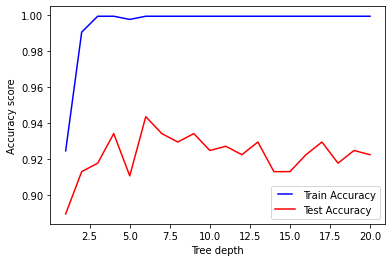

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Creating the empty lists to add the results of the training and test accuracy as well as a list from 1-32 to iterate the depth 
train_results = []
test_results = []
max_depths = np.linspace(1, 20, 20, endpoint=True)
for max_depth in max_depths:
    rf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=max_depth, random_state=0).fit(Xtrain, Ytrain)
    train_pred = rf.predict(Xtrain)

    # Appending the accuracy score of the prediction on the training set for various depths
    train_results.append(accuracy_score(Ytrain, train_pred))

    test_pred = rf.predict(Xtest)

    # Appending the accuracy score of the prediction on the test set for various depths
    test_results.append(accuracy_score(Ytest, test_pred))


from matplotlib.legend_handler import HandlerLine2D


line1, = plt.plot(max_depths, train_results, "b", label="Train Accuracy")
line2, = plt.plot(max_depths, test_results, "r", label="Test Accuracy")



plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("Tree depth")
plt.show()



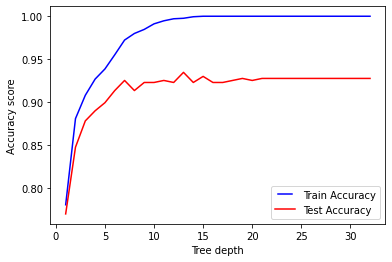

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Creating the empty lists to add the results of the training and test accuracy as well as a list from 1-32 to iterate the depth 
train_results = []
test_results = []
max_depths = np.linspace(1, 32, 32, endpoint=True)
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, random_state=0).fit(Xtrain, Ytrain)
    train_pred = rf.predict(Xtrain)

    # Appending the accuracy score of the prediction on the training set for various depths
    train_results.append(accuracy_score(Ytrain, train_pred))

    test_pred = rf.predict(Xtest)

    # Appending the accuracy score of the prediction on the test set for various depths
    test_results.append(accuracy_score(Ytest, test_pred))


from matplotlib.legend_handler import HandlerLine2D


line1, = plt.plot(max_depths, train_results, "b", label="Train Accuracy")
line2, = plt.plot(max_depths, test_results, "r", label="Test Accuracy")



plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("Tree depth")
plt.show()








As can be seen in the graph above the test accuracy drops significantly when we increase the depth whilst the training accuracy increases towards 100% correct predictions.
This result is expected due to that the model is overfitting when we are increasing the depth. We also see that for the Gradient boosting classifier this overfitting happens much faster than it does for the Random Forest. 

We therefor chose to go forward with the Random forest as our model selection. By studying the graph we see that a depth of around 6 would be optimal since we then obtain the highest accuracy without increasing the complexity unnecessarily or overfitting the model to the training data.  
 
One interesting observation is that the test accuracy doesnt drop as the model is overfitting to the training data. This suggests that the data itself has alot of similarities across the covariates, allowing the model to still accurately predict/generalize on new data, even when it is overfitted.

In [ ]:
from sklearn.metrics import accuracy_score
RF_final = RandomForestClassifier(max_depth=6, random_state=0).fit(Xtrain, Ytrain)
Yguess = RF_final.predict(Xtest)
print(accuracy_score(Ytest, Yguess))

0.9131455399061033


As mentioned earlier a random forest is an ensamble of a set of Decision Trees that are combined together to give a more accurate result, which will be less prone to overfitting. 
To create a random forests the two techniques bootstrapping and features randomness is utilized. 
Bootstrapping is to divide the original dataset into subsets through randomly extracting a few of the samples. 
Once you have bootstrapped the data, i.e. randomly extracted a few samples from the original dataset the features should also be selected randomly. 
Feature randomness, similarly to bootstrapping, is to randomly extract a few of the features/attributes from the data. 
Once you have bootstrapped and selected some features randomly a decision tree is built on that subset of the original data. 
The process of bootstrapping, extracting random features and building decision trees is then repeated until one has a random forest that give a satisfactory 
accuracy on the data. 

How many times one should repeat the process, i.e. how many individual trees that has to be included in the random forest varies from case to case
nd one always has bear in that the more trees one include the higher the time for computation. The number of trees are however correlated to the size of the dataset, 
one can generally say that for a small dataset a smaller number of trees are needed to give accurate predictions and similarly for large dataset a larger number of 
trees are required. 

# Task 2 - See separate file

# Task 3

In [ ]:
import numpy as np
# Read the CSV file using Pandas.
alldata = pd.read_csv('sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
m1 = DummyRegressor()
m1_cv = cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

m1_cv.get('test_score').mean()

-0.38925247260237567

# Testing Different classifiers

### Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr_cv = cross_validate(lr, Xtrain, Ytrain, scoring='neg_mean_squared_error' )
print(lr_cv)
lr_cv.get('test_score').mean()

{'fit_time': array([0.00809956, 0.00660038, 0.00637674, 0.00801682, 0.01851654]), 'score_time': array([0.01242781, 0.00305724, 0.00301576, 0.00288844, 0.00294924]), 'test_score': array([-0.30222063, -0.32537384, -0.29377903, -0.29296258, -0.29265721])}


-0.30139865887671935

### Ridge

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 1.0)

ridge_cv = cross_validate(ridge, Xtrain, Ytrain, scoring='neg_mean_squared_error' )
print(ridge_cv)
ridge_cv.get('test_score').mean()

{'fit_time': array([0.00664067, 0.01327872, 0.01288223, 0.02259111, 0.007864  ]), 'score_time': array([0.00875449, 0.00575542, 0.00546885, 0.00348043, 0.00420833]), 'test_score': array([-0.30222063, -0.32537046, -0.29377831, -0.29296256, -0.29265724])}


-0.3013978423217981

### Lasso

In [ ]:
from sklearn import linear_model

lm = linear_model.Lasso(alpha=1.0)

lm_cv = cross_validate(lm, Xtrain, Ytrain, scoring='neg_mean_squared_error' )
print(lm_cv)
lm_cv.get('test_score').mean()

{'fit_time': array([0.0058744 , 0.00738978, 0.02340317, 0.00857377, 0.0061028 ]), 'score_time': array([0.02842331, 0.00326991, 0.00621462, 0.00448823, 0.00357032]), 'test_score': array([-0.31042005, -0.29379119, -0.29803599, -0.30061325, -0.30237486])}


-0.3010470671748872

### Descision Tree Regressor 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state = 0)

dtr_cv = cross_validate(dtr, Xtrain, Ytrain, scoring='neg_mean_squared_error' )
print(dtr_cv)
dtr_cv.get('test_score').mean()


{'fit_time': array([0.05609059, 0.0607295 , 0.06274772, 0.05907893, 0.0498476 ]), 'score_time': array([0.00300574, 0.00438285, 0.00412631, 0.00292206, 0.00315642]), 'test_score': array([-0.52740361, -0.54577063, -0.5054554 , -0.50183335, -0.55465489])}


-0.5270235772655832

### Random Forest Regressor 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=2, random_state = 0)

rf_reg_cv = cross_validate(rf_reg, Xtrain, Ytrain, scoring='neg_mean_squared_error' )
print(rf_reg_cv)
rf_reg_cv.get('test_score').mean()


{'fit_time': array([0.60998535, 0.52431965, 0.50729728, 0.51762772, 0.46877289]), 'score_time': array([0.01977491, 0.02077675, 0.01811004, 0.01773381, 0.01269484]), 'test_score': array([-0.30660535, -0.28378306, -0.29688942, -0.30035284, -0.29904841])}


-0.29733581591151304

### Gradient Boosting Regressor 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(random_state = 0)

gb_reg_cv = cross_validate(gb_reg, Xtrain, Ytrain, scoring='neg_mean_squared_error' )
print(gb_reg_cv)
gb_reg_cv.get('test_score').mean()

{'fit_time': array([0.71467829, 0.70821548, 0.70821095, 0.69550252, 0.69791198]), 'score_time': array([0.0054028 , 0.00577402, 0.0073843 , 0.00576615, 0.00552726]), 'test_score': array([-0.27648513, -0.24920729, -0.2629464 , -0.27079364, -0.26331844])}


-0.2645501801671458

### MLP Regressor 

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(random_state = 0, max_iter=500)

mlp_reg_cv = cross_validate(mlp_reg, Xtrain, Ytrain, scoring='neg_mean_squared_error' )

print(mlp_reg_cv)
mlp_reg_cv.get('test_score').mean()


{'fit_time': array([23.24596262, 19.86662745,  5.8788147 , 17.12120795, 17.98016953]), 'score_time': array([0.00512242, 0.01072311, 0.01313543, 0.00521207, 0.00494695]), 'test_score': array([-101.19698697,   -8.81196082,   -6.45970728,   -8.22771164,
         -2.23506527])}


-25.386286395552997

## Interpreting the results of cross_validate

Looking at the results above we look at the test_score for each and every classifier.
The score given is the negated mean squared error, which should be minimized as far as possible
to attain the best model. 

To see which model that gives the best result we have calculated the mean value of 
the crossvalidation across all the different regression models. The model that gives 
the smallest mean cv value is generated from the MLP Regressor model which comes to -25.386 
however this result is abit misleading since the MLP model gives one output that comes to approx -101.197.
This is because this model trains iteratively on the data to fit the data better and better. 

This high variance in the MSE can result in poor performance for the model when evaluating
on the full dataset. 



## Final evaluation of the models

Below we have tried to fit each and every model on the full dataset and then calculated
the mean_squared_error. This gives a positive output where smaller values are better and with 
0.0 being the best. 

In [ ]:
from sklearn.metrics import mean_squared_error

regr = gb_reg

# The results from the 
# m1 = 0.4 Dummy model for baseline reference
# mlp_reg = 1.64
# dtr = 0.55
# lm = 0.32
# ridge = 0.315
# lr = 0.315 
# rf_reg = 0.3 
# gb_reg = 0.27

regr.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, regr.predict(Xtest))

0.27136199343052597

We can see from the result above the the MLP regressor model indeed performs very poorly
and give alot higher score then the dummy model m1 on the MSE. Also the dtr model gives
a worse performance than the baseline. 

From the test we see that the Gradient boosting regressor model performs the best, and this is 
also the model that gives the next to lowest CV MSE mean value. 

## Final model


The final model of choice therefore become the Gradient Boosting regressor model 
which outputs a MSE of 0.27 when fitted to the whole dataset as can be seen below.

In [ ]:
from sklearn.metrics import mean_squared_error

gb_reg.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, gb_reg.predict(Xtest))


0.27136199343052597

The Gradiant Booting model is much like a random forest, where it is using an ensamble
of decision trees that combined gives the final result. The depth of each tree can be configured
through the hyper parameters, as well as the number of trees with a default of 100 trees and 
a depth of 3 of each tree. To try and better the performance we will iterate over both these 
parameters. 

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
1
2
3
4


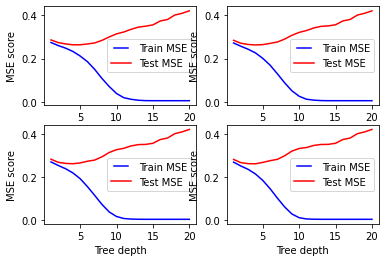

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Creating the empty lists to add the results of the training and test accuracy as well as a list from 1-32 to iterate the depth 
train_results = np.array([[1],[], [], [], []])
test_results = np.array([[1],[], [], [], []])
max_depths = np.linspace(1, 20, 20, endpoint=True)

for i in range(1,5): 
    for max_depth in max_depths:
        rf = GradientBoostingRegressor(n_estimators=100 + i*50, max_depth=max_depth, random_state = 0).fit(Xtrain, Ytrain)
        train_pred = rf.predict(Xtrain)

        # Appending the accuracy score of the prediction on the training set for various depths
        train_results[i].append(mean_squared_error(Ytrain, train_pred))

        test_pred = rf.predict(Xtest)

        # Appending the accuracy score of the prediction on the test set for various depths
        test_results[i].append(mean_squared_error(Ytest, test_pred))


from matplotlib.legend_handler import HandlerLine2D

for i in range(1, 5):
    plt.subplot(2, 2, i)
    print(i)

    line1, = plt.plot(max_depths, train_results[i], "b", label="Train MSE")
    line2, = plt.plot(max_depths, test_results[i], "r", label="Test MSE")

    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("MSE score")
    plt.xlabel("Tree depth")


plt.show()

As can be seen from the generated graphs, the number of trees in the model does not affect the result that much, since the results are overlapping alot over each iteration.
The parameter that affects the result the most is the depth of the trees in the model and we can see as the depth increases, the training MSE goes to 0.0 while the test MSE
increases alot. 

From analysing the graphs we can see that a tree depth of around 5 is gives the best performance for the test MSE so the final model will contain 
the default 100 trees with tree depth of 5, as below:

In [ ]:
from sklearn.metrics import mean_squared_error


gb_reg_final = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state = 0).fit(Xtrain, Ytrain)

mean_squared_error(Ytest, gb_reg_final.predict(Xtest))

0.26405492251107027

The final model gives the output of 0.264 MSE on the test set with the Gradient Boosting Regressor.

# Task 4

## Step 1

Adding the DecisionTreeLeaf, DecisionTreeBranch and DecisionTree classes to be used in the TreeRegressor class. 

In [ ]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [ ]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

In [ ]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be 
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

### Creating the TreeRegressor class

In [ ]:
from sklearn.base import RegressorMixin
class TreeRegressor(DecisionTree, RegressorMixin):


    def __init__(self, max_depth = 10, threshold = 0):
        super().__init__(max_depth)
        self.threshold = threshold

    def fit(self, X, Y):
        # For tree regressors, we use variance reduction to measure
        # the homogeneity of subsets.
        self.variance = np.var(Y)
        self.tree_size = np.size(Y)

        super().fit(X, Y)
        
    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the mean value.
    def get_default_value(self, Y):
        return np.mean(Y)
    
    # Checks whether a set of output values is homogeneous. In the regression case,
    # this means that the variance is under a threshold.
    def is_homogeneous(self, Y):
        return np.var(Y) <= self.threshold * np.max(Y)
    

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):


        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # Size of the lower and higher part
        low_size = 0
        high_size = self.tree_size
        
        #Sums and sums of squares for the lower and higher parts
        low_sum = 0
        high_sum = np.sum(Y)
        low_sum_squares = 0
        high_sum_squares = np.sum(Y**2)
        
        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None
        
        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the sizes of the parts.
            low_size += 1
            high_size -= 1
            
            # Update the sums and sums of squares
            low_sum += y_i
            high_sum -= y_i
            low_sum_squares += y_i**2
            high_sum_squares -= y_i**2
            
            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue
                
            # Calculate the variances for the lower and higher parts
            high_var = high_sum_squares / high_size - high_sum**2 / high_size**2
            low_var = low_sum_squares / low_size - low_sum**2 / low_size**2
            
            # Compute the homogeneity criterion for a split at this position.
            score = self.variance - high_size / self.tree_size * high_var - \
                    low_size / self.tree_size * low_var

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + Y_sorted[max_i+1])
        return max_score, feature, split_point

In [ ]:
from sklearn.base import RegressorMixin
class TreeRegressor(DecisionTree, RegressorMixin):


    def __init__(self, max_depth = 10, threshold = 0):
        super().__init__(max_depth)
        self.threshold = threshold

    def fit(self, X, Y):
        # For tree regressors, we use variance reduction to measure
        # the homogeneity of subsets.
        self.variance = np.var(Y)
        self.tree_size = np.size(Y)

        super().fit(X, Y)
        
    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the mean value.
    def get_default_value(self, Y):
        return np.mean(Y)
    
    # Checks whether a set of output values is homogeneous. In the regression case,
    # this means that the variance is under a threshold.
    def is_homogeneous(self, Y):
        return np.var(Y) <= self.threshold * np.max(Y)
    

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):


        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(X_sorted)

        # Size of the lower and higher part
        low_size = 0
        high_size = self.tree_size
        
        #Sums and sums of squares for the lower and higher parts
        low_sum = 0
        high_sum = np.sum(Y)
        low_sum_squares = 0
        high_sum_squares = np.sum(Y**2)
        
        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None
        
        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the sizes of the parts.
            low_size += 1
            high_size -= 1
            
            # Update the sums and sums of squares
            low_sum += y_i
            high_sum -= y_i
            low_sum_squares += y_i**2
            high_sum_squares -= y_i**2
            
            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue
                
            # Calculate the variances for the lower and higher parts
            high_var = high_sum_squares / high_size - high_sum**2 / high_size**2
            low_var = low_sum_squares / low_size - low_sum**2 / low_size**2
            
            # Compute the homogeneity criterion for a split at this position.
            score = self.variance - high_size / self.tree_size * high_var - \
                    low_size / self.tree_size * low_var

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + Y_sorted[max_i+1])
        return max_score, feature, split_point

## Step 2

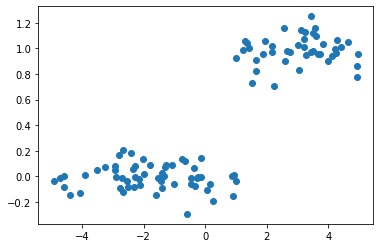

In [ ]:
from matplotlib import pyplot 
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

X, Y = make_some_data(100)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
pyplot.scatter(X, Y) #The graph looks just as expected

With the data above we would probably only need a tree of depth = 1 since the data is splitted in two distinct groups, any further splitting would not make any sense and just 
introduce unnecessary complexity. Since the data is very homogeneous already we will set a pretty high threshold to mirror this.

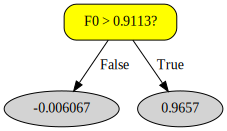

In [ ]:
regressor = TreeRegressor(max_depth=1, threshold=0.1)
regressor.fit(Xtrain, Ytrain)
regressor.draw_tree()

If we we try to increase the depth of the tree we get the following: 

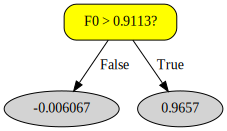

In [ ]:
regressor = TreeRegressor(max_depth=3, threshold=0.1)
regressor.fit(Xtrain, Ytrain)
regressor.draw_tree()

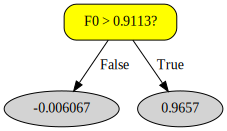

In [ ]:
regressor = TreeRegressor(max_depth=6, threshold=0.1)
regressor.fit(Xtrain, Ytrain)
regressor.draw_tree()

As we can see with the current threshold of 0.1 the data does not get splitted any more when we are increasing the depth of the trees.

## Step 3

In [ ]:
test_tree = TreeRegressor(max_depth=5, threshold=0.1)

test_tree.fit(Xtrain, Ytrain)

# Testing the predicted score with MSE
Ypred = test_tree.predict(Xtest)
score = mean_squared_error(Ytest, Ypred)
score

0.10819195737602876

This result is worse than what we got with the Gradiant boosting model in Task 3. This was with a max_depth of 5, the same as the gradient boosting and with a threshold of 0.1 

side note: when decreasing the threshold the following error comes: "KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([ 0, 11041, 2507, 11035, 2515,\n ...\n 8422, 5272, 2311, 5278, 11180],\n dtype='int64', length=10906). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"
and we cannot figure out why in time.. 

## Step 4

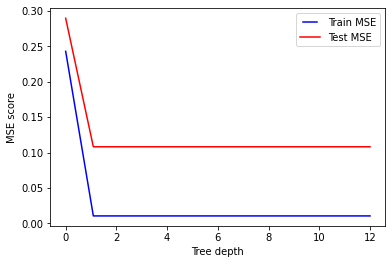

In [ ]:
training_results_tree = []
test_results_tree = []
max_depths_tree = np.linspace(0, 12, 12, endpoint=True)
for max_depth in max_depths_tree:
    reg_tree = TreeRegressor(max_depth=max_depth, threshold= 0.1)
    reg_tree.fit(Xtrain, Ytrain)

    train_pred = reg_tree.predict(Xtrain)
    #Appending the result to the list
    training_results_tree.append(mean_squared_error(Ytrain, train_pred))

    test_pred = reg_tree.predict(Xtest)
    #Appending the test result to the list
    test_results_tree.append(mean_squared_error(Ytest, test_pred))

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths_tree, training_results_tree, "b", label="Train MSE")
line2, = plt.plot(max_depths_tree, test_results_tree, "r", label="Test MSE")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("MSE score")
plt.xlabel("Tree depth")

plt.show()


In [ ]:
We see that the result quickly goes down to around 0.1 after the tree depth is increased by 1 and then it does not improve further. Which indicated that the data is already splitted homogeneously after 
the depth is increased to 1 and does not improve further by increasing the depth. Keep in mind that this still is with the threshold of 0.1 and decreasing this should also allow the 
tree and the result to improve. 